## Imports & setup

In [1]:
import setup
setup.main()

import os

os.environ["GEOMSTATS_BACKEND"] = "pytorch"

import geomstats.backend as gs

from geomstats.geometry.pullback_metric import PullbackMetric

import matplotlib.pyplot as plt

import neuralgeom.datasets.gridcells as gridcells
from viz import plot_grid_rate_maps, plot_grids
import numpy as np

%load_ext autoreload
%autoreload 2
%matplotlib inline

Working directory:  /Users/facosta/Desktop/code/neuralgeom/neuralgeom
Directory added to path:  /Users/facosta/Desktop/code/neuralgeom
Directory added to path:  /Users/facosta/Desktop/code/neuralgeom/neuralgeom


INFO: Using pytorch backend


## Define diffeomorphism $\varphi: \mathbb{R}^2 \to \mathbb{R}^2$

$(x,y) \mapsto ((1 + \frac{\gamma}{(1 + x^2 + y^2)^{\alpha}})x, (1 + \frac{\gamma}{(1 + x^2 + y^2)^{\beta}})y)$

$\gamma \in \mathbb{R}, \alpha, \beta \in \mathbb{R}_{+}$ parameterize the deformation

In [2]:
def get_plane_warp(alpha, beta, gamma):
    
    def plane_warp(point):
        x = point[0]
        y = point[1]
        
        f_x = (1 + gamma/(1 + x**2 + y**2)**alpha)*x
        f_y = (1 + gamma/(1 + x**2 + y**2)**beta)*y
        
        f_point = gs.array([f_x,f_y])
        
        return f_point
    
    return plane_warp

In [ ]:
#TODO: define inverse diffop

### Instantiate + plot warp

In [3]:
warp = get_plane_warp(alpha=2, beta=0.5, gamma=-0.4)

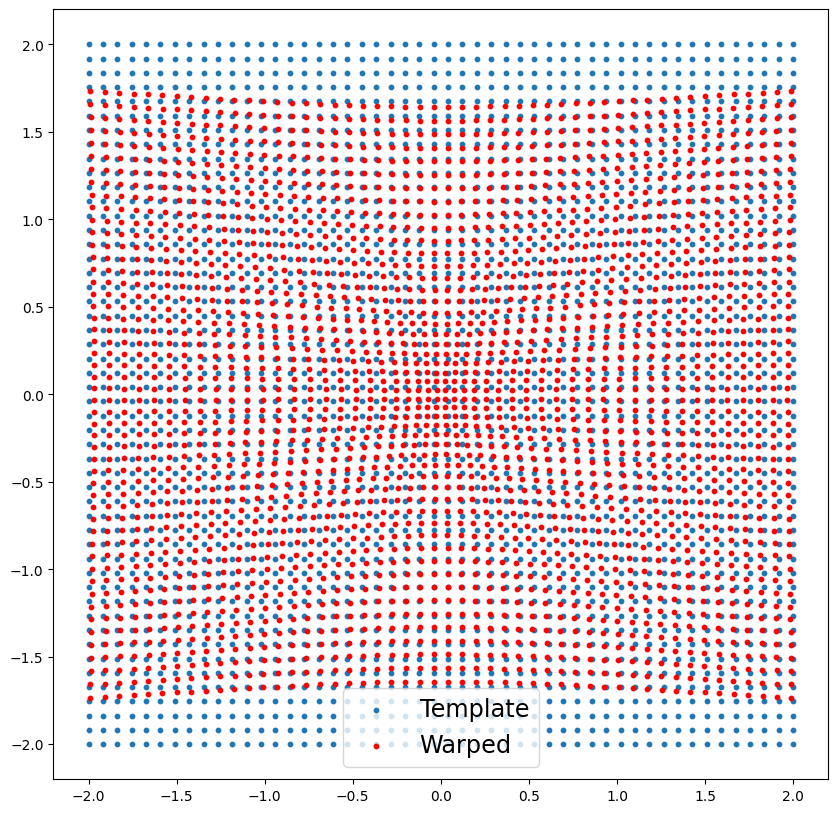

In [4]:
x = gs.linspace(-2,2,50)
y = gs.linspace(-2,2,50)
x_grid, y_grid = gs.meshgrid(x,y)
x_grid_warp, y_grid_warp = warp((x_grid,y_grid))
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.scatter(x_grid,y_grid, s=10, label="Template")
ax.scatter(x_grid_warp,y_grid_warp,s=10, label="Warped", c= "red")
ax.legend(fontsize="xx-large")

## Compute pull-back metric $(\varphi^*g)_{ij} = \partial_{i}\varphi^{a}\partial_{j}\varphi^{b}g_{ab}$

In [5]:
pullback_metric = PullbackMetric(dim=2,embedding_dim=2,immersion=warp)

In [8]:
from geomstats.geometry.pullback_metric import PullbackDiffeoMetric
from geomstats.geometry.euclidean import Euclidean

class NeuralPullbackDiffeoMetric(PullbackDiffeoMetric):
    def __init__(self):
        super().__init__(space=Euclidean(dim=2))
    def _define_embedding_space(self):
        return Euclidean(dim=2)
    def diffeormorphism(self, base_point):
        return warp(base_point)
    def inverse_diffeormorphism(self, base_point):
        return warp(base_point)

pullback_diffeo_metric = NeuralPullbackDiffeoMetric()

TypeError: Can't instantiate abstract class NeuralPullbackDiffeoMetric with abstract methods define_embedding_metric, diffeomorphism, inverse_diffeomorphism

### Quick distance check 

In [6]:
point_a = gs.array([0.0,0.0])
point_b = gs.array([1.0,1.0])
pullback_metric.dist(point_a,point_b)

tensor(1.2201)

### Quick metric matrix check

In [7]:
pullback_metric.metric_matrix(point_a)

tensor([[0.3600, 0.0000],
        [0.0000, 0.3600]])

## Plot volume element $\sqrt{|\text{det}(g)|}$

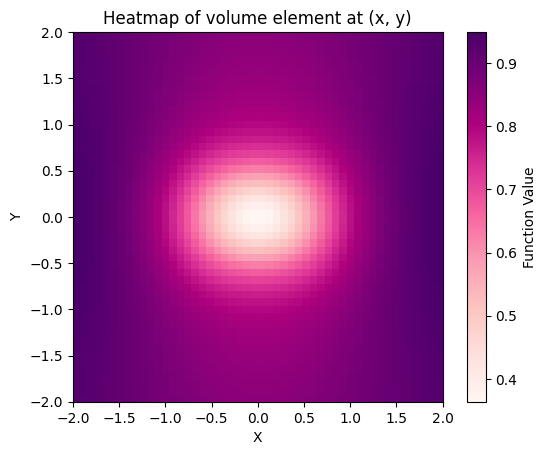

In [8]:
# Combine and reshape the x and y coordinates into a list of 2D points
points = gs.vstack((x_grid.ravel(), y_grid.ravel())).T

# Define your function
def volume_element(x, y):
    point = gs.array([x,y])
    g = pullback_metric.metric_matrix(point)
    vol = gs.sqrt(gs.abs(gs.linalg.det(g)))
    return vol

# Apply the function to each point in the list
values = gs.array([volume_element(x, y) for x, y in points])

# Reshape the values back into a 2D grid
z_values = values.reshape(x_grid.shape)

# Create the heatmap
plt.imshow(z_values, origin='lower', extent=[x.min(), x.max(), y.min(), y.max()], cmap='RdPu')
plt.colorbar(label='Function Value')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Heatmap of volume element at (x, y)')
plt.show()

## TODO -- Visualize geodesic grid

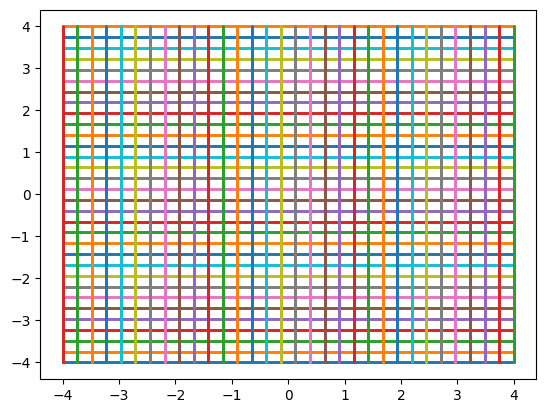

In [9]:
"""Plot a grid on H2 with Poincare Disk visualization."""

import matplotlib.pyplot as plt

import geomstats.backend as gs
import geomstats.visualization as visualization
from geomstats.geometry.hyperboloid import Hyperboloid

# H2 = Hyperboloid(dim=2)
# METRIC = H2.metric

from geomstats.geometry.euclidean import Euclidean

R2 = Euclidean(dim=2)
METRIC = R2.metric

left=-4.0
right=4.0
bottom=-4.0
top=4.0
grid_size=32
n_steps=512


"""Plot a grid on H2 with Poincare Disk visualization.

Parameters
----------
left, right, bottom, top : ints
    Grid's coordinates
grid_size : int
    Grid's size.
n_steps : int
    Number of steps along the geodesics defining the grid.
"""
starts = []
ends = []
for p in gs.linspace(left, right, grid_size):
    starts.append(gs.array([top, p]))
    ends.append(gs.array([bottom, p]))
for p in gs.linspace(top, bottom, grid_size):
    starts.append(gs.array([p, left]))
    ends.append(gs.array([p, right]))
    
# starts = [H2.from_coordinates(s, "intrinsic") for s in starts]
# ends = [H2.from_coordinates(e, "intrinsic") for e in ends]
ax = plt.gca()
for start, end in zip(starts, ends):
    geodesic = METRIC.geodesic(initial_point=start, end_point=end)

    t = gs.linspace(0.0, 1.0, n_steps)
    points_to_plot = geodesic(t)
    # visualization.plot(
    #     points_to_plot, ax=ax, space="H2_poincare_disk", marker=".", s=1
    # )
    plt.scatter(points_to_plot[:,0],points_to_plot[:,1], s=1)

## Synthetic grid cell deformations

### Grid cell parameters

In [10]:
grid_scale = 2
arena_dims = np.array([4, 4])
n_cells = 8
grid_orientation_mean = 0
grid_orientation_std = 0
field_width = 0.1
resolution = 50
lx = grid_scale
ly = grid_scale * np.sqrt(3) / 2

### Create grid + deformed grid

In [11]:
grids, grids_warped = gridcells.generate_all_grids(
    grid_scale, arena_dims, n_cells, grid_orientation_mean, grid_orientation_std, warp=warp)

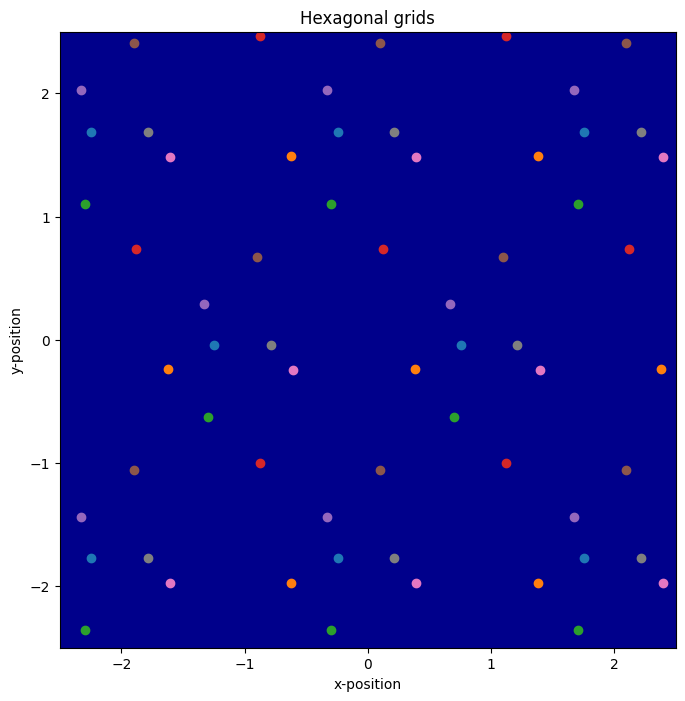

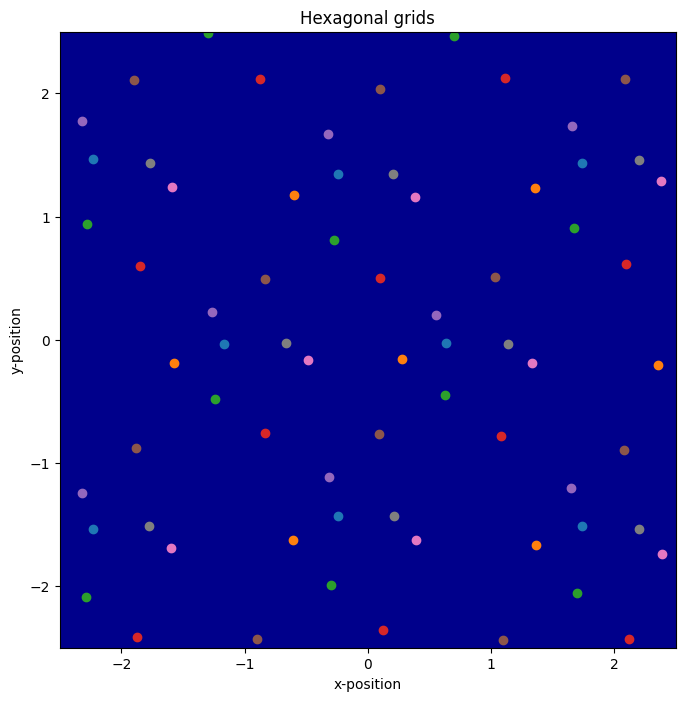

In [12]:
plot_grids(grids, arena_dims)
plot_grids(grids_warped, arena_dims)

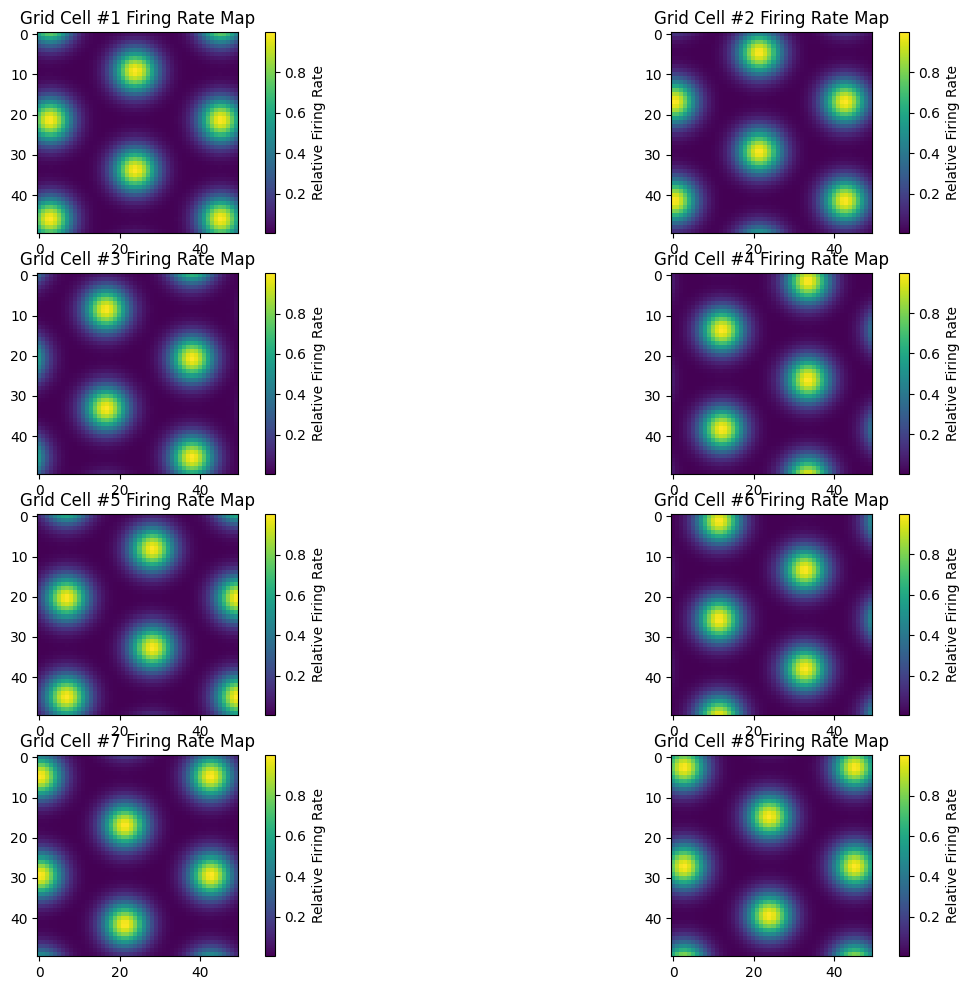

In [13]:
rate_maps = gridcells.create_rate_maps(grids, field_width, arena_dims, resolution)
plot_grid_rate_maps(rate_maps)

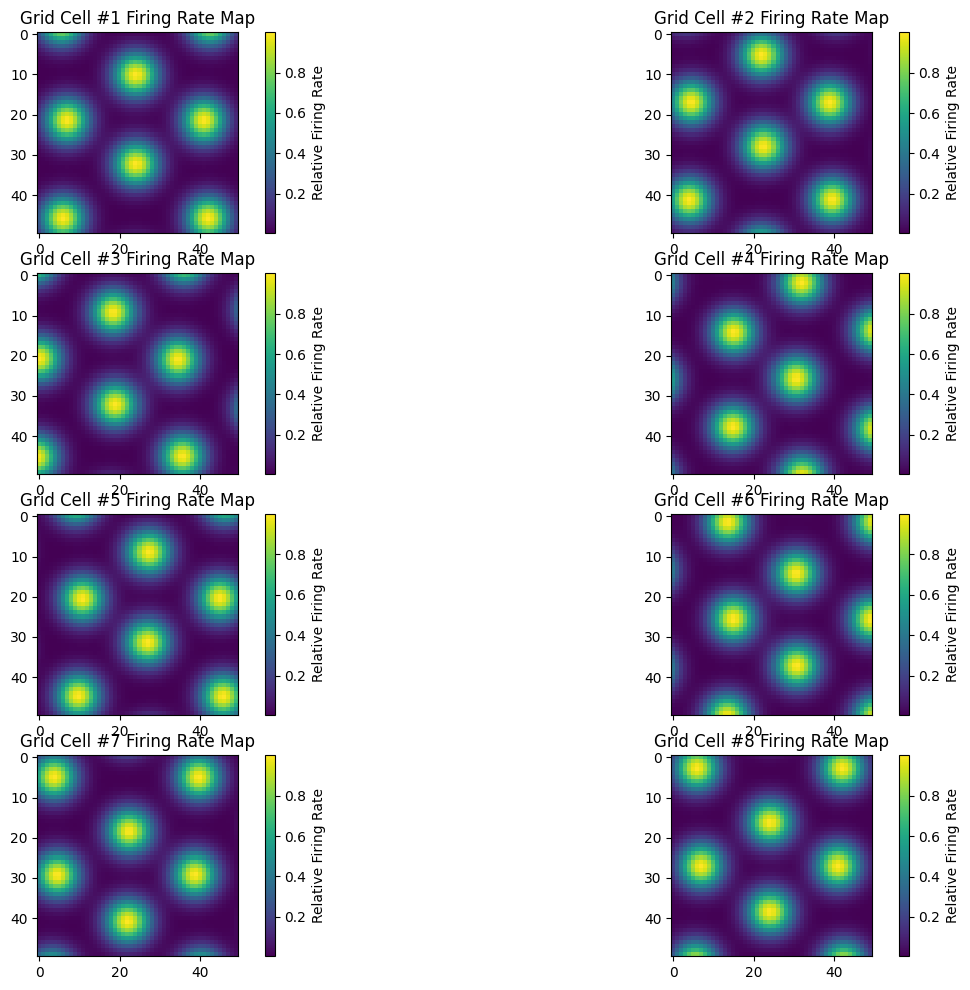

In [14]:
rate_maps_warped = gridcells.create_rate_maps(grids_warped, field_width, arena_dims, resolution)
plot_grid_rate_maps(rate_maps_warped)

## Apply LDDMM algorithm to grid cell maps

In [16]:
import pyLDDMM

from pyLDDMM.utils.visualization import loadimg, saveimg, save_animation, plot_warpgrid

In [17]:
i0 = rate_maps[0]

i1 = rate_maps_warped[0]

In [18]:
lddmm = pyLDDMM.LDDMM2D()
im, v, energies, length, Phi0, Phi1, J0, J1 = lddmm.register(i0, i1, sigma=0.1, alpha=1, epsilon=0.0001, K=500)

iteration   0, energy 7356.55, thereof 0.00 regularization and 7356.55 intensity difference
iteration   1, energy 6838.51, thereof 3.54 regularization and 6834.97 intensity difference
iteration   2, energy 6367.28, thereof 6.96 regularization and 6360.32 intensity difference
iteration   3, energy 5938.25, thereof 10.25 regularization and 5928.00 intensity difference
iteration   4, energy 5547.29, thereof 13.42 regularization and 5533.88 intensity difference
iteration   5, energy 5190.54, thereof 16.47 regularization and 5174.07 intensity difference
iteration   6, energy 4861.58, thereof 19.41 regularization and 4842.16 intensity difference
iteration   7, energy 4557.26, thereof 22.25 regularization and 4535.01 intensity difference
iteration   8, energy 4275.87, thereof 24.97 regularization and 4250.89 intensity difference
iteration   9, energy 4016.48, thereof 27.59 regularization and 3988.88 intensity difference
iteration  10, energy 3778.18, thereof 30.12 regularization and 3748.06 i

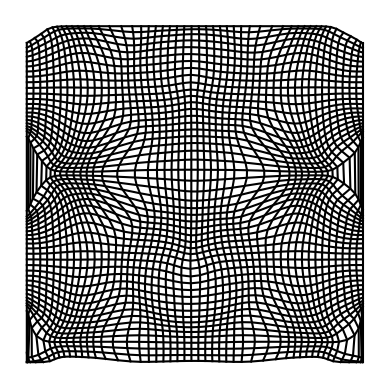

In [25]:
plot = plot_warpgrid(Phi0[-1], interval=1)